In [ ]:
'''
RFM,
K-Means,
Hierarchical_Clustering.
'''

In [1]:
# Импортируем библиотеки для работы с датафреймами
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Импортитруем библиотеки для K-Means и кластеризации
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
retail = pd.read_csv('https://github.com/mikhailag570/Online_Retail_RFM_K-Means_end_Hierarchical_Clustering/blob/main/OnlineRetail.csv.zip/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)   # Не забываем указывать кодировку ISO
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
'''
Очистка данных
'''

In [6]:
# Вычасление процента пропущенных значений

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
# Удаление пустых строк

retail = retail.dropna()
retail.shape

(406829, 8)

In [8]:
# Изменение типа данных CustomerID

retail['CustomerID'] = retail['CustomerID'].astype(str)

In [ ]:
'''
Подготовка данных
Мы собираемся проанализировать клиентов на основе следующих 3 факторов:
R (последние): количество дней с момента последней покупки.
F (частота): количество транзакций
M (денежный): общая сумма транзакций (внесенный доход)
'''

In [9]:
# Атрибут M

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
# Атрибут F

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
# Объединим два датафрейма через inner

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
# Атрибут R
# Преобразуем datetime в верный формат

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [13]:
# Определим максимальную дату, как дату последней транзакции.

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# Найдем разницу между максимальной датой и датой транзакции

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# Определим дату последней транзакции, чтобы узнать актуальность клиентов.

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
# Извлечем только количество дней

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [17]:
# Получим окончательный RFM датафрейм

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [ ]:
'''
Выбросы могут исказить картину, поэтому будем рассматривать :
1. Статистические
2. Доменные
'''

Text(0.5, 0, 'Attributes')

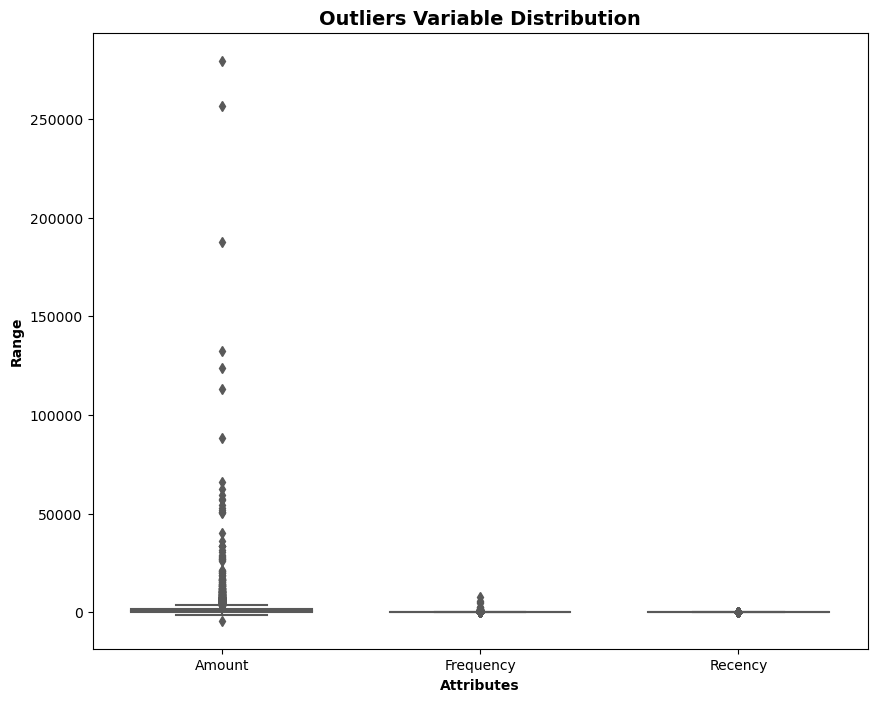

In [18]:
# Анализ выбросов

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [21]:
# Удаление выбросов

Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [ ]:
'''
Изменение масштаба атрибутов.
Важно!
Изменим масштаб переменных, чтобы они были в общей картине.
Существуют два (самых распространенных) метода Min-Max scaling и Standardisation (mean-0, sigma-1)
Воспользуемся вторым способом.
'''

In [22]:
# Изменение масштаба атрибутов

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Создадим экземпляр
scaler = StandardScaler()

# Преобразуем с  fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4271, 3)

In [23]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.759639,-0.771795,2.295613
1,1.916220,1.117217,-0.910045
2,0.356175,-0.467454,-0.187782
3,0.331534,-0.026685,-0.741847
4,-0.552027,-0.614377,2.137309


In [ ]:
'''
Построение модели.
Кластеризация K-Means.
Кластеризация K-Means — один из самых простых и популярных алгоритмов машинного обучения без учителя.
'''

In [24]:
# k-means с некоторым произвольным k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [25]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [ ]:
'''
Метод Elbow — один из самых популярных методов определения оптимального значения k.
'''

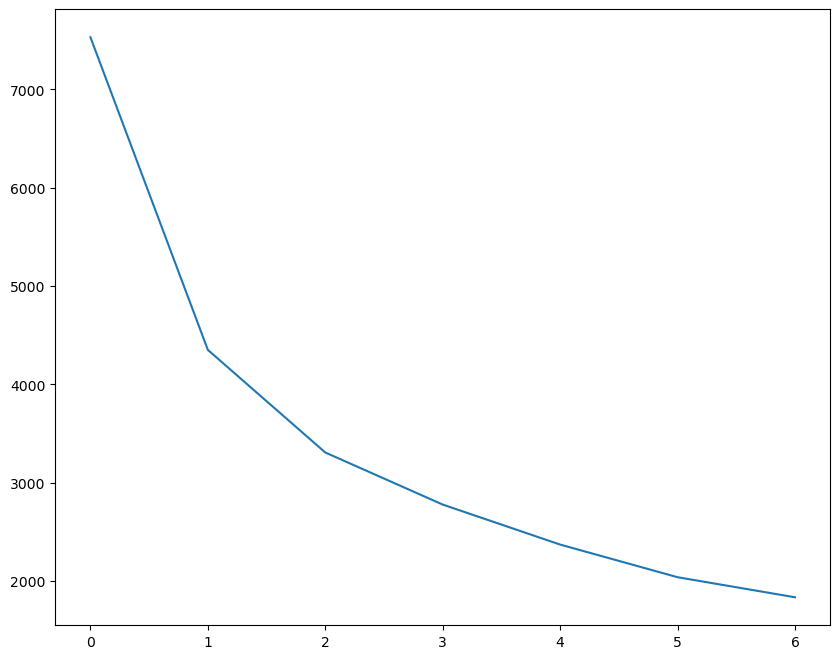

In [26]:
# Elbow-кривая/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# построим SSD для каждого n-кластера
plt.plot(ssd)

In [ ]:
'''
p  - это среднее расстояние до точек ближайшего кластера, частью которого точка данных не является.

q  - среднее внутрикластерное расстояние до всех точек в его собственном кластере.

Значение диапазона оценки силуэта находится в диапазоне от -1 до 1.

Оценка ближе к 1 означает, что точка данных очень похожа на другие точки данных в кластере.

Оценка ближе к -1 указывает на то, что точка данных не похожа на точки данных в своем кластере.
'''

In [29]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # Инициализируем kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # Силует
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("Для n_clusters={0}, силует равен {1}".format(num_clusters, silhouette_avg))

Для n_clusters=2, силует равен 0.5256379303486981
Для n_clusters=3, силует равен 0.5022535831650203
Для n_clusters=4, силует равен 0.4781646507106878
Для n_clusters=5, силует равен 0.4611592349310209
Для n_clusters=6, силует равен 0.4138624144221166
Для n_clusters=7, силует равен 0.40679764440686833
Для n_clusters=8, силует равен 0.39954839916265983


In [30]:
# Финальная модель для k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [31]:
kmeans.labels_

array([0, 2, 1, ..., 0, 1, 1])

In [32]:
# Назначим label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

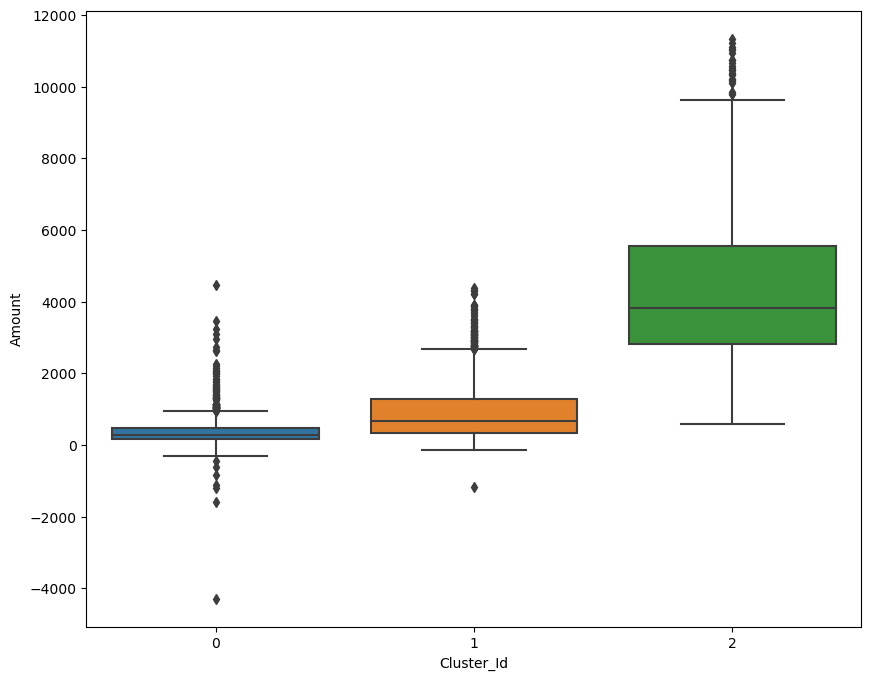

In [33]:
# Визуализируем boxplot Cluster_Id против Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

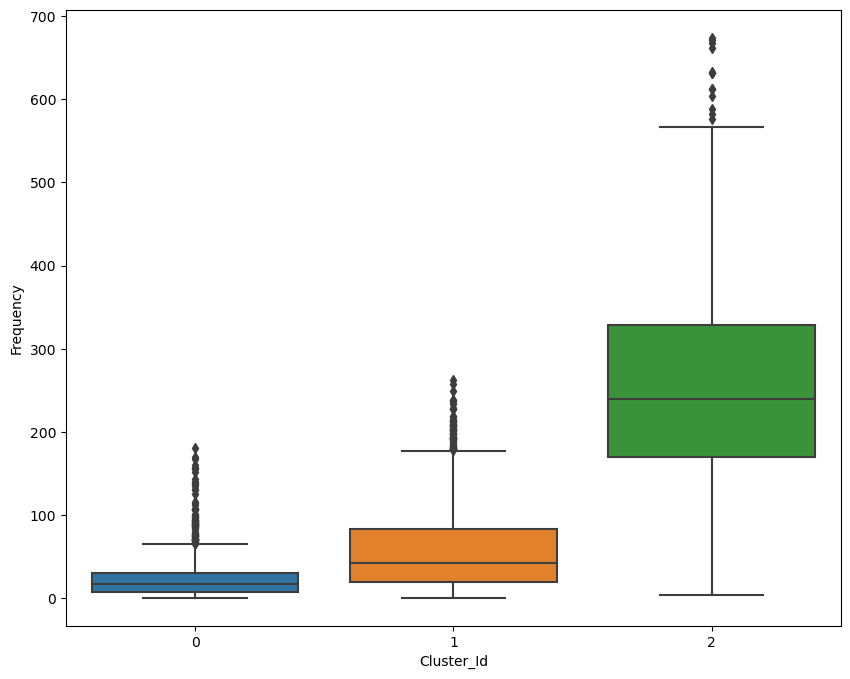

In [34]:
# Визуализируем boxplot Cluster_Id против Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

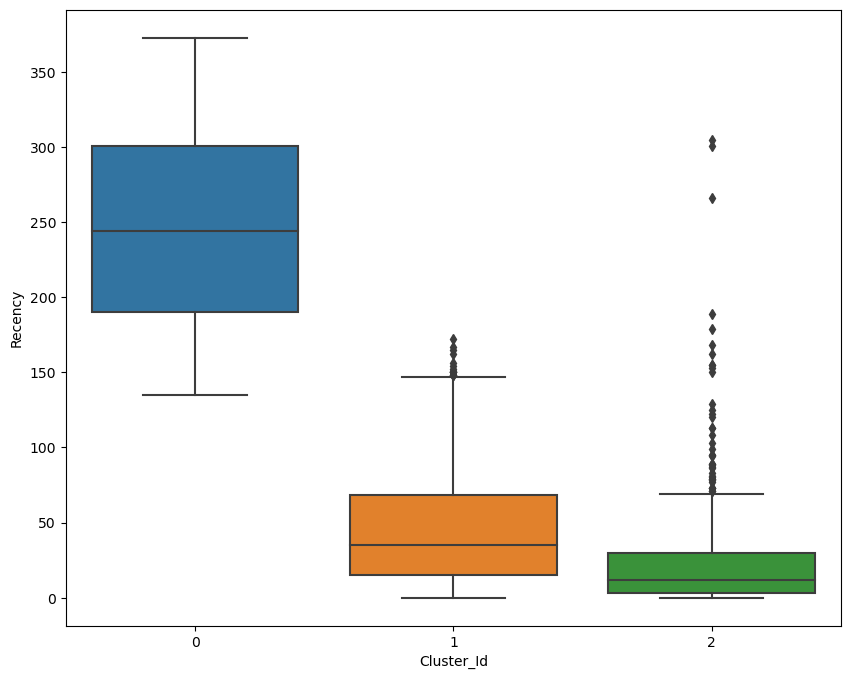

In [35]:
# Визуализируем boxplot Cluster_Id против Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

In [ ]:
'''
Иерархическая кластеризация.
Иерархическая кластеризация предполагает создание кластеров, имеющих заранее определенный порядок сверху вниз. 
Например, все файлы и папки на жестком диске организованы в иерархию. Существует два типа иерархической кластеризации:
1. Разделяющий,
2. Агломерационный.

Одиночная связь:
При иерархической кластеризации с одной связью расстояние между двумя кластерами определяется как кратчайшее расстояние 
между двумя точками в каждом кластере. 
Например, расстояние между кластерами «r» и «s» слева равно длине стрелки между двумя их ближайшими точками.
'''

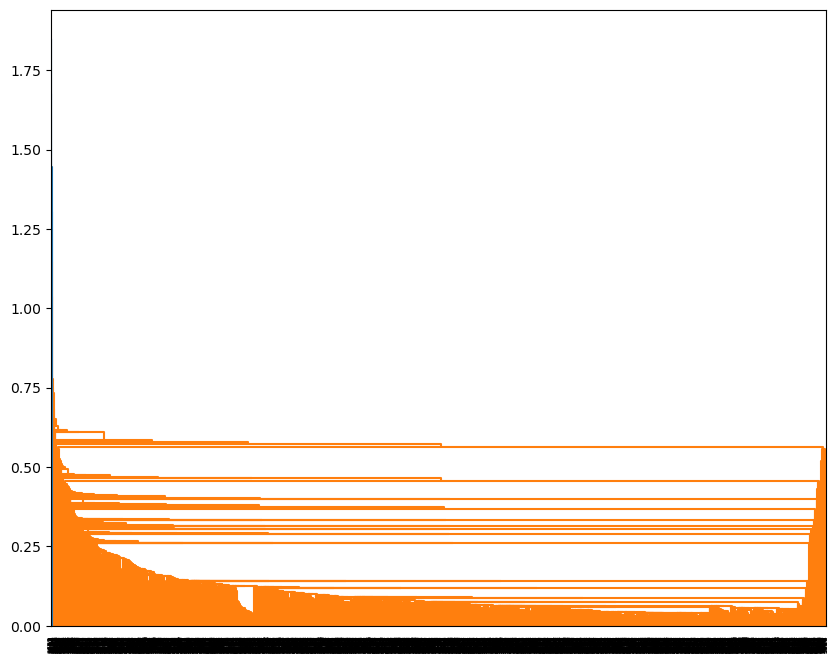

In [36]:
# Одиночная связь.

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

In [ ]:
'''
Полная связь.
При иерархической кластеризации с полной связью расстояние между двумя кластерами определяется как самое длинное расстояние 
между двумя точками в каждом кластере. 
Например, расстояние между кластерами «r» и «s» слева равно длине стрелки между их двумя самыми дальними точками.
'''

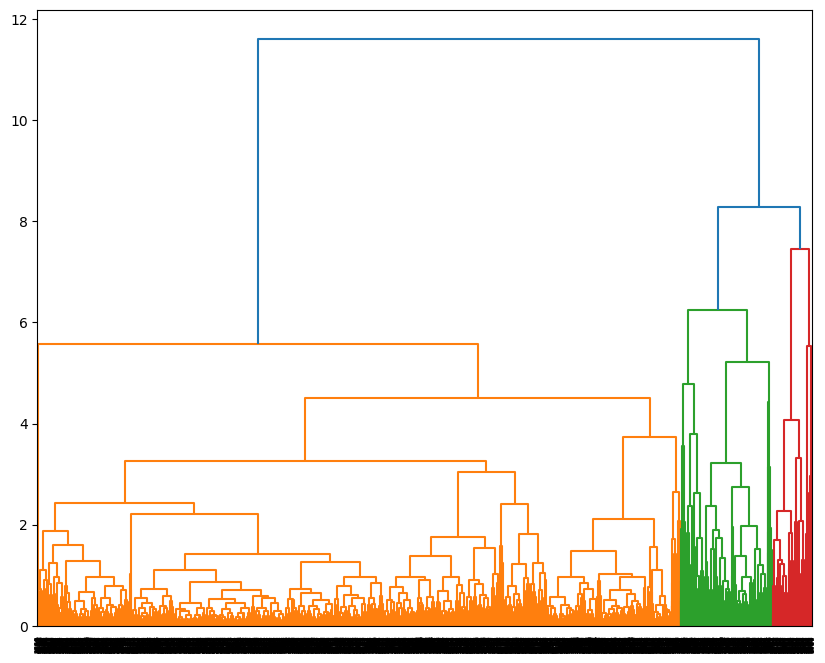

In [37]:
# Полная связь.

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [ ]:
'''
Средняя связь.
При иерархической кластеризации средней связи расстояние между двумя кластерами определяется как среднее расстояние 
между каждой точкой одного кластера и каждой точкой другого кластера. Например, расстояние между кластерами «r» и «s» слева 
равно средней длине каждой стрелки между соединениями точек одного кластера с другим.
'''

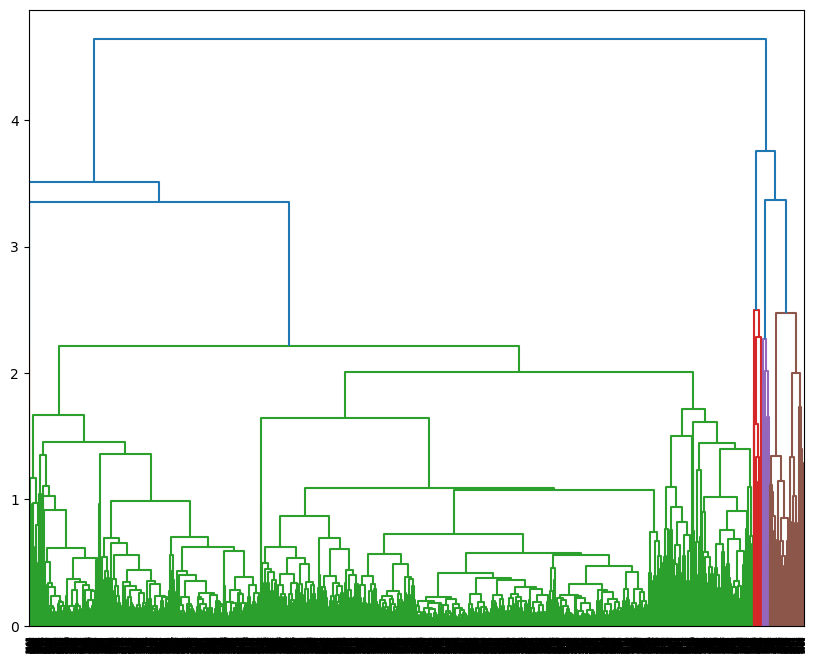

In [38]:
# Средняя связь.

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [ ]:
'''
Разрезание дендрограммы на основе K
'''

In [39]:
# 3 кластеры
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
# Назначаем cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,2,0
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,0,0


In [ ]:
'''
Выводим три boxplot с Cluster_Labels
'''

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Amount'>

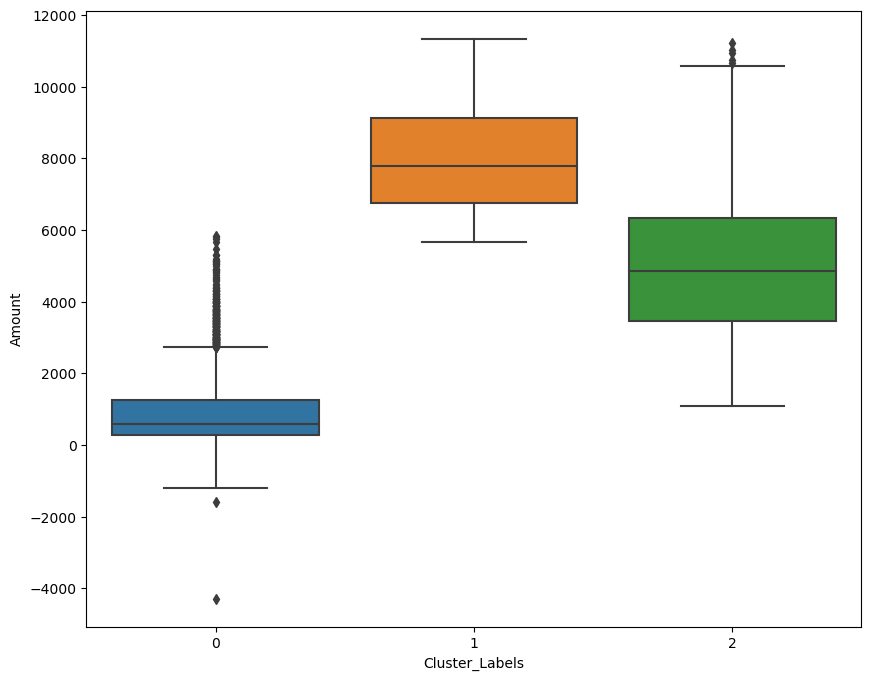

In [41]:
sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Frequency'>

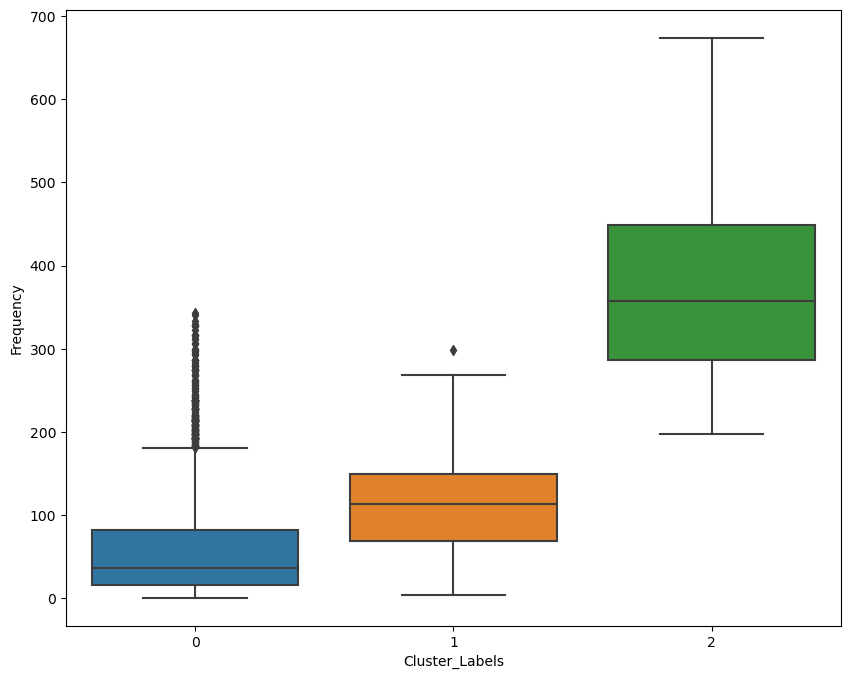

In [42]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='Recency'>

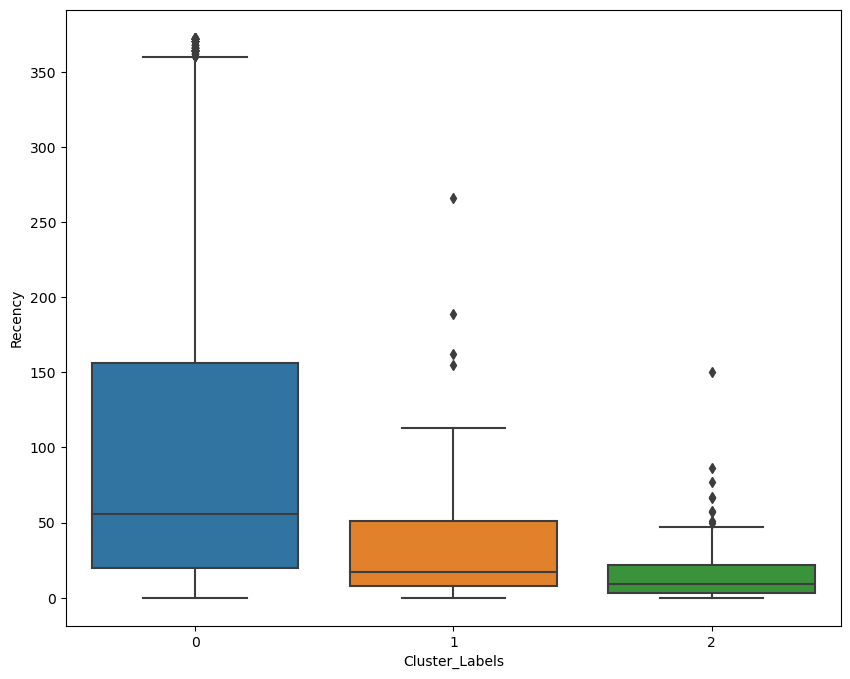

In [43]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

In [ ]:
'''
Вывод:
Кластеризация K-средних с 3 идентификаторами кластера

Клиенты с идентификатором кластера 2 — это клиенты с большим количеством транзакций по сравнению с другими клиентами.
Клиенты с идентификатором кластера 2 являются частыми покупателями.
Клиенты с идентификатором кластера 2 не являются недавними покупателями и, следовательно, наименее важны с точки зрения бизнеса.

Иерархическая кластеризация с тремя метками кластера

Клиенты с Cluster_Labels 1 — это клиенты с большим количеством транзакций по сравнению с другими клиентами.
Клиенты с Cluster_Labels 2 — частые покупатели.
Клиенты с Cluster_Labels 2 не являются недавними покупателями и, следовательно, наименее важны с точки зрения бизнеса.
'''